# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [25]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [26]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 13, 19, 13, 23, 434603)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [27]:
project = hopsworks.login()
if os.environ.get("HOPSWORKS_API_KEY") is None:
    os.environ["HOPSWORKS_API_KEY"] = open(".hw_key").read()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1157271
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [28]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [29]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [30]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.902366E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>

In [31]:
weather_fg = fs.get_feature_group(
    name="weather",
    version=1,
)
weather_fg.expectation_suite.run_validation = False
air_quality_fg = fs.get_feature_group(
    name="air_quality",
    version=1,
)
air_quality_fg.expectation_suite.run_validation = False
air_quality_df_all = air_quality_fg.read().sort_values("date", ascending=False)
air_quality_df = air_quality_df_all.head(3)
lagged = air_quality_df["pm25"].mean()
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data["lagged"] = lagged
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged
0,2024-11-16 00:00:00+00:00,7.75,0.0,2.620839,164.054535,reutlingen,29.313334
1,2024-11-21 00:00:00+00:00,2.15,0.0,13.004921,274.763550,reutlingen,29.313334
2,2024-11-14 00:00:00+00:00,6.25,0.0,4.072935,224.999893,reutlingen,29.313334
3,2024-11-20 00:00:00+00:00,4.35,0.3,10.383987,236.309906,reutlingen,29.313334
4,2024-11-19 00:00:00+00:00,11.70,0.0,12.849528,168.690109,reutlingen,29.313334
5,2024-11-15 00:00:00+00:00,7.90,0.0,1.835647,78.690102,reutlingen,29.313334
6,2024-11-18 00:00:00+00:00,8.95,0.3,19.770523,236.888641,reutlingen,29.313334
7,2024-11-17 00:00:00+00:00,11.05,0.0,16.923830,231.911179,reutlingen,29.313334
8,2024-11-22 00:00:00+00:00,1.85,0.0,10.972620,228.991013,reutlingen,29.313334


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [32]:
batch_data["predicted_pm25"] = retrieved_xgboost_model.predict(
    batch_data[["lagged", "temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"]])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged,predicted_pm25
0,2024-11-16 00:00:00+00:00,7.75,0.0,2.620839,164.054535,reutlingen,29.313334,15.980580
1,2024-11-21 00:00:00+00:00,2.15,0.0,13.004921,274.763550,reutlingen,29.313334,14.434836
2,2024-11-14 00:00:00+00:00,6.25,0.0,4.072935,224.999893,reutlingen,29.313334,15.096938
3,2024-11-20 00:00:00+00:00,4.35,0.3,10.383987,236.309906,reutlingen,29.313334,12.632482
4,2024-11-19 00:00:00+00:00,11.70,0.0,12.849528,168.690109,reutlingen,29.313334,8.223283
5,2024-11-15 00:00:00+00:00,7.90,0.0,1.835647,78.690102,reutlingen,29.313334,15.520988
6,2024-11-18 00:00:00+00:00,8.95,0.3,19.770523,236.888641,reutlingen,29.313334,4.232752
7,2024-11-17 00:00:00+00:00,11.05,0.0,16.923830,231.911179,reutlingen,29.313334,7.220751
8,2024-11-22 00:00:00+00:00,1.85,0.0,10.972620,228.991013,reutlingen,29.313334,22.042765


In [33]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   lagged                       9 non-null      float32            
 7   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(6), object(1)
memory usage: 492.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [34]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged,predicted_pm25,street,country,days_before_forecast_day
2,2024-11-14 00:00:00+00:00,6.25,0.0,4.072935,224.999893,reutlingen,29.313334,15.096938,zaisentalstraße,germany,1
5,2024-11-15 00:00:00+00:00,7.90,0.0,1.835647,78.690102,reutlingen,29.313334,15.520988,zaisentalstraße,germany,2
0,2024-11-16 00:00:00+00:00,7.75,0.0,2.620839,164.054535,reutlingen,29.313334,15.980580,zaisentalstraße,germany,3
7,2024-11-17 00:00:00+00:00,11.05,0.0,16.923830,231.911179,reutlingen,29.313334,7.220751,zaisentalstraße,germany,4
6,2024-11-18 00:00:00+00:00,8.95,0.3,19.770523,236.888641,reutlingen,29.313334,4.232752,zaisentalstraße,germany,5
4,2024-11-19 00:00:00+00:00,11.70,0.0,12.849528,168.690109,reutlingen,29.313334,8.223283,zaisentalstraße,germany,6
3,2024-11-20 00:00:00+00:00,4.35,0.3,10.383987,236.309906,reutlingen,29.313334,12.632482,zaisentalstraße,germany,7
1,2024-11-21 00:00:00+00:00,2.15,0.0,13.004921,274.763550,reutlingen,29.313334,14.434836,zaisentalstraße,germany,8
8,2024-11-22 00:00:00+00:00,1.85,0.0,10.972620,228.991013,reutlingen,29.313334,22.042765,zaisentalstraße,germany,9


In [35]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2 to 8
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   lagged                       9 non-null      float32            
 7   predicted_pm25               9 non-null      float32            
 8   street                       9 non-null      object             
 9   country                      9 non-null      object             
 10  days_before_forecast_day     9 non-null      int64         

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

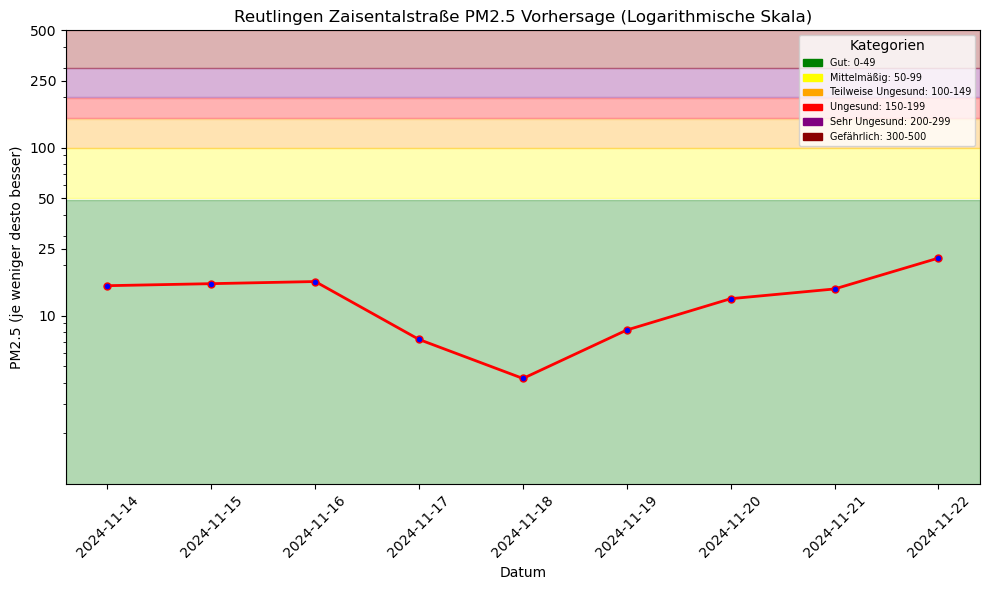

In [36]:
file_path = "../docs/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [37]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)
monitor_fg.expectation_suite.run_validation = False

In [38]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1157271/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1a495322c90>, None)

In [39]:
# monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
# We take all past data.
monitoring_df = monitor_fg.filter(monitor_fg.date < today).read()
# We use the most recent prediction for that day.
# The reason we do this is sometimes our day-before prediction is not there due to Hopsworks.
monitoring_df = monitoring_df.loc[monitoring_df.groupby("date")["days_before_forecast_day"].idxmin()]
# We sort the predictions and only take the last 10 days.
monitoring_df = monitoring_df.sort_values("date", ascending=False).head(10)
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-16 00:00:00+00:00,7.750000,0.0,2.620839,164.054535,reutlingen,29.313334,15.980580,zaisentalstraße,germany,1
1,2024-11-06 00:00:00+00:00,9.116834,0.0,7.458606,19.536776,reutlingen,0.000000,8.256969,zaisentalstraße,germany,1
2,2024-11-08 00:00:00+00:00,7.056417,0.0,7.127636,141.185257,reutlingen,0.000000,8.239414,zaisentalstraße,germany,1
3,2024-11-09 00:00:00+00:00,7.337667,0.0,7.309419,164.744766,reutlingen,0.000000,9.611665,zaisentalstraße,germany,1
4,2024-11-10 00:00:00+00:00,5.950000,0.0,4.024922,26.564985,reutlingen,0.000000,12.140126,zaisentalstraße,germany,1
5,2024-11-04 00:00:00+00:00,5.910583,0.0,6.924738,158.442795,reutlingen,0.000000,10.497578,zaisentalstraße,germany,1
6,2024-11-03 00:00:00+00:00,7.448083,0.0,7.895416,121.260376,reutlingen,0.000000,8.858627,zaisentalstraße,germany,1
7,2024-11-05 00:00:00+00:00,8.996001,0.0,6.696387,220.955399,reutlingen,0.000000,7.266383,zaisentalstraße,germany,1
8,2024-11-07 00:00:00+00:00,7.250166,0.0,8.996398,24.087471,reutlingen,0.000000,11.773292,zaisentalstraße,germany,1
9,2024-11-02 00:00:00+00:00,8.408500,0.2,11.638917,57.269035,reutlingen,0.000000,3.789554,zaisentalstraße,germany,1


In [40]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_fg.expectation_suite.run_validation = False
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.08s) 


,date,pm25,lagged,country,city,street,url
0,2022-10-05 00:00:00+00:00,3.10,4.133333,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
1,2023-04-07 00:00:00+00:00,4.12,5.073333,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
2,2023-04-11 00:00:00+00:00,1.42,6.580000,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
3,2021-09-15 00:00:00+00:00,3.80,3.550000,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
4,2020-04-26 00:00:00+00:00,1.98,2.890000,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
...,...,...,...,...,...,...,...
1785,2024-04-17 00:00:00+00:00,2.20,1.993333,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
1786,2019-12-20 00:00:00+00:00,4.48,4.976666,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
1787,2021-05-23 00:00:00+00:00,0.80,0.990000,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451
1788,2024-11-12 00:00:00+00:00,33.00,9.866667,germany,reutlingen,zaisentalstraße,https://api.waqi.info/feed/A54451


In [41]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25', 'days_before_forecast_day']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = pd.read_csv(os.path.join("..", "data", "hindcast-backup.csv"))
    hindcast_df["date"] = pd.to_datetime(hindcast_df["date"])
    hindcast_df["temperature_2m_mean"] = hindcast_df["temperature_2m_mean"].astype("float32")
    hindcast_df["precipitation_sum"] = hindcast_df["precipitation_sum"].astype("float32")
    hindcast_df["wind_speed_10m_max"] = hindcast_df["wind_speed_10m_max"].astype("float32")
    hindcast_df["wind_direction_10m_dominant"] = hindcast_df["wind_direction_10m_dominant"].astype("float32")
    hindcast_df["predicted_pm25"] = hindcast_df["predicted_pm25"].astype("float32")
    hindcast_df["pm25"] = hindcast_df["pm25"].astype("float32")
    # We are restoring pre-lag values, so we fill with dummy 0.
    hindcast_df["lagged"] = 0.0
    hindcast_df["lagged"] = hindcast_df["lagged"].astype("float32")
    df = hindcast_df
    df = df.drop('pm25', axis=1)
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    # hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

2024-11-13 00:00:00+00:00
2024-11-16 00:00:00+00:00
Dates in outcome_df but not in preds_df:
0      2022-10-05 00:00:00+00:00
1      2023-04-07 00:00:00+00:00
2      2023-04-11 00:00:00+00:00
3      2021-09-15 00:00:00+00:00
4      2020-04-26 00:00:00+00:00
                  ...           
1785   2024-04-17 00:00:00+00:00
1786   2019-12-20 00:00:00+00:00
1787   2021-05-23 00:00:00+00:00
1788   2024-11-12 00:00:00+00:00
1789   2024-11-13 00:00:00+00:00
Name: date, Length: 1780, dtype: datetime64[us, UTC]
Dates in preds_df but not in outcome_df:
0    2024-11-16 00:00:00+00:00
11   2024-11-14 00:00:00+00:00
Name: date, dtype: datetime64[us, UTC]
2024-11-11 00:00:00+00:00


,date,predicted_pm25,days_before_forecast_day,pm25
8,2024-11-02 00:00:00+00:00,3.789554,1,8.60
5,2024-11-03 00:00:00+00:00,8.858627,1,7.40
4,2024-11-04 00:00:00+00:00,10.497578,1,6.42
6,2024-11-05 00:00:00+00:00,7.266383,1,7.10
0,2024-11-06 00:00:00+00:00,8.256969,1,7.89
7,2024-11-07 00:00:00+00:00,11.773292,1,14.33
1,2024-11-08 00:00:00+00:00,8.239414,1,4.03
2,2024-11-09 00:00:00+00:00,9.611665,1,5.53
3,2024-11-10 00:00:00+00:00,12.140126,1,9.66
9,2024-11-11 00:00:00+00:00,9.966185,1,6.94


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

2024-11-13 19:15:47,469 WARNING: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



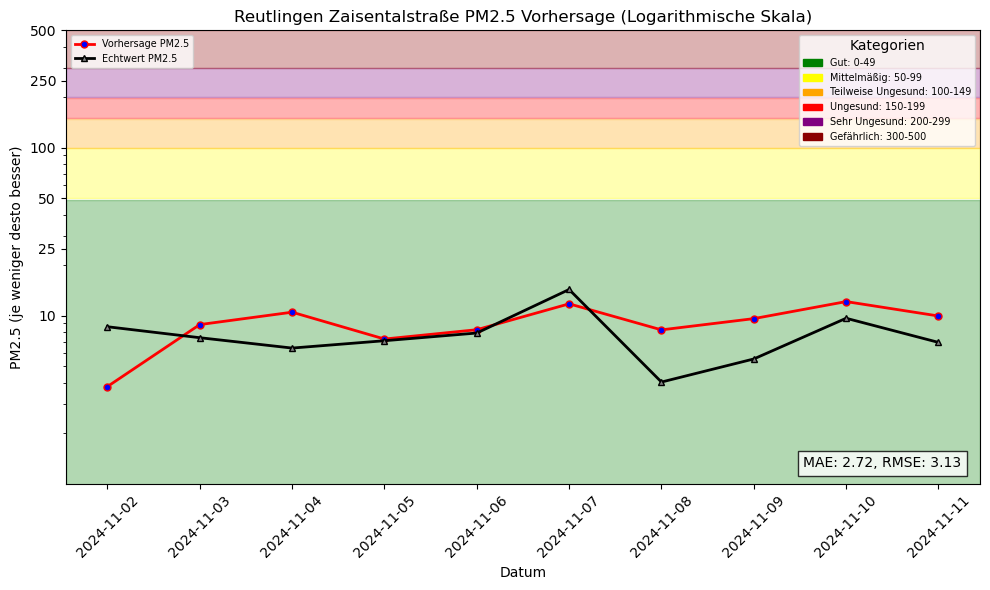

In [44]:
file_path = "../docs/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---

## More Evaluation

In [43]:
# Check error depending on days before forecast

# Check if days_before_forecast_day is a column in the hindcast_df
if 'days_before_forecast_day' in hindcast_df.columns:
    hindcast_df['error'] = hindcast_df['pm25'] - hindcast_df['predicted_pm25']
    error_by_days_before_forecast = hindcast_df.groupby('days_before_forecast_day')['error'].mean()
    error_by_days_before_forecast.head()